<a href="https://colab.research.google.com/github/Jeba-Rachel-Nesica/image-segmenting/blob/main/satellite_image_building_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
map_base_dir = '/content/drive/MyDrive/input/'
map_img_dir = '/content/drive/MyDrive/input/train/images'
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

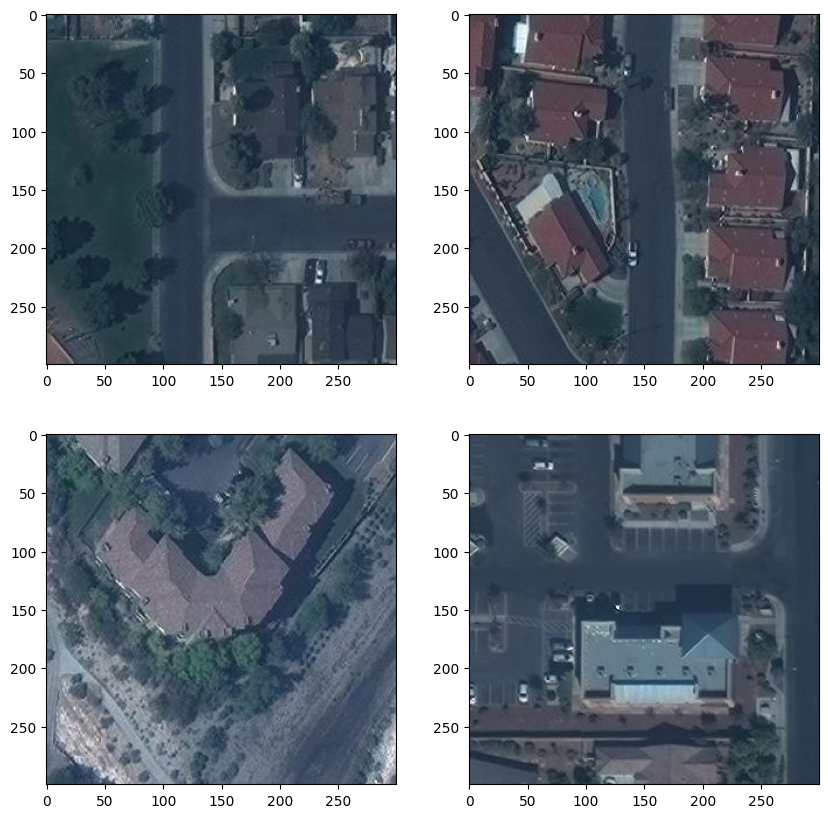

In [ ]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [ ]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
1055127  1582648    185638  [[300, 275, 273, 275, 273, 241, 273, 224, 300,...   
990734    412902     48475  [[196.0, 157.0, 173.0, 157.0, 173.0, 176.0, 14...   
615065     86206     10193  [[279.0, 222.0, 262.0, 193.0, 268.0, 187.0, 26...   

           area                         bbox  category_id  iscrowd  
1055127  1377.0           [241, 273, 59, 27]          100        0  
990734   3483.0   [111.0, 140.0, 85.0, 56.0]          100        0  
615065   1763.0  [146.0, 262.0, 154.0, 38.0]          100        0

In [ ]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


id_x  image_id                                       segmentation  \
458423   1988957    233333  [[99.99999999999999, 62.0, 113.99999999999999,...   
1710965  1686872    197812  [[218.0, 300.0, 218.0, 300.0, 190.0, 300.0, 19...   

          area                                               bbox  \
458423   154.0  [62.0, 99.99999999999999, 51.999999999999986, ...   
1710965    0.0                        [190.0, 190.0, 110.0, 28.0]   

         category_id  iscrowd    id_y         file_name  width  height  
458423           100        0  233333  000000233333.jpg    300     300  
1710965          100        0  197812  000000197812.jpg    300     300

In [ ]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']

        box_list += [Rectangle((start_x, start_y),
                         wid_y , wid_x
                         )]
    return box_list

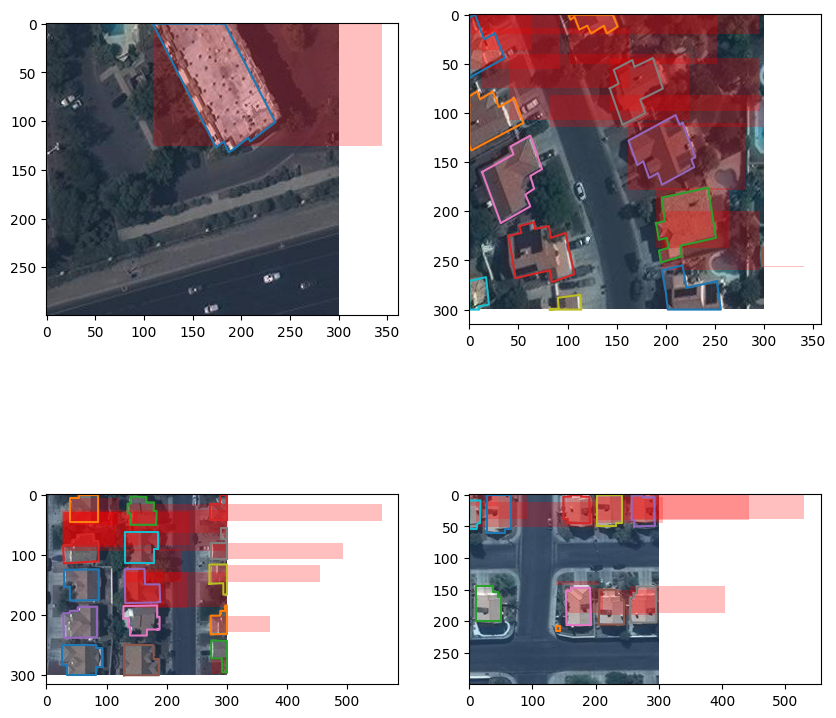

In [ ]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

# Convert Polygons to Segmentations
We can use the `Path` function of matplotlib on a `np.meshgrid` of $x,y$ values in order to convert the polygon into a binary image to use as the segmentation.

In [ ]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]),
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(),
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

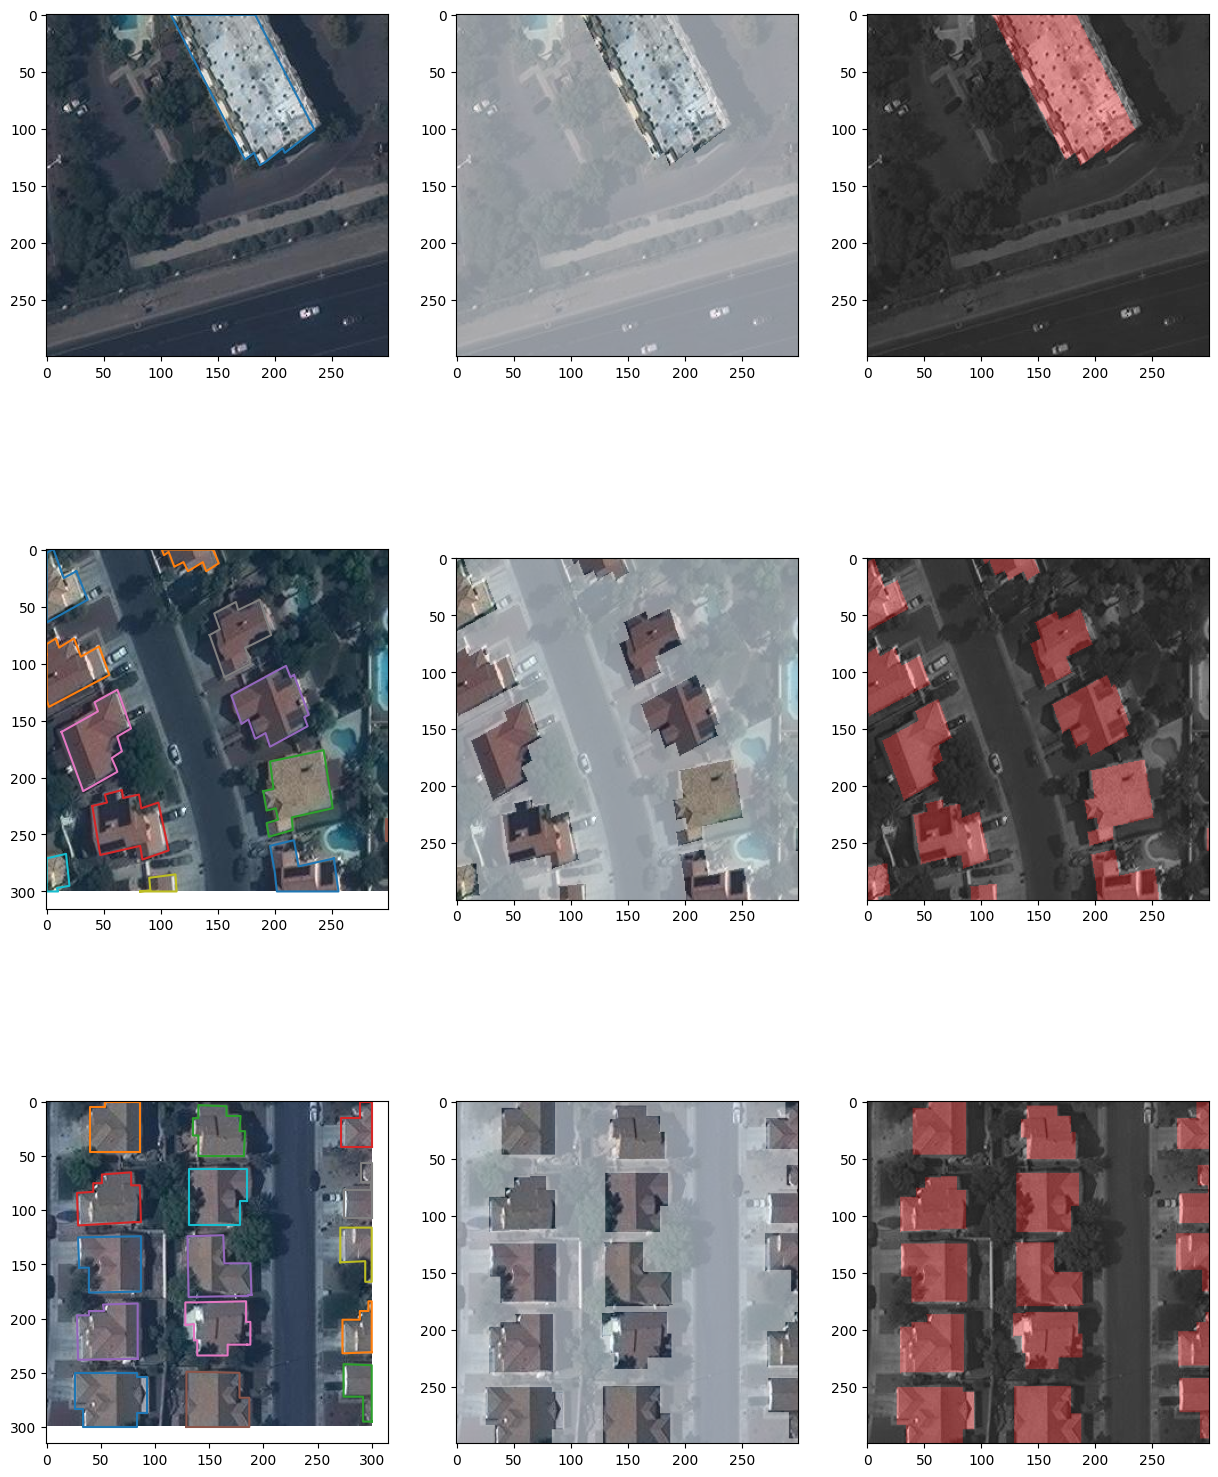

In [ ]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data,
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)

    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1799084 training boxes
596469 validation boxes


In [ ]:
'''def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)'''


"def batch_img_gen(in_df, batch_size):\n    all_groups = list(in_df.groupby('image_id'))\n    out_img, out_seg = [], []\n    while True:\n        for (_, c_df) in np.random.permutation(all_groups):\n            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))\n            out_img += [img_data]\n            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]\n            if len(out_img)>=batch_size:\n                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)\n                out_img, out_seg = [], []\nvalid_gen = batch_img_gen(valid_df, 8)"

In [ ]:
!pip install scikit-image
!pip install --upgrade scikit-image


In [ ]:

from skimage.util import montage



In [ ]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    while True:
        np.random.shuffle(all_groups)  # Shuffle the groups to randomize the order
        out_img, out_seg = [], []
        for (_, c_df) in all_groups:
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img.append(img_data)
            out_seg.append(np.expand_dims(rows_to_segmentation(img_data, c_df), -1))
            if len(out_img) >= batch_size:
                yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
        # If the loop completes without yielding a batch, shuffle and continue
        if not out_img:
            continue

valid_gen = batch_img_gen(valid_df, 8)

In [ ]:
def create_montage(image_list):
    """
    Create a montage from a list of images.

    Args:
    - image_list: List of images (2D or 3D arrays)

    Returns:
    - montage: Montage image
    """
    num_images = len(image_list)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    # Determine dimensions of each image
    height, width, channels = image_list[0].shape

    montage = np.zeros((rows * height, cols * width, channels), dtype=image_list[0].dtype)

    for i, image in enumerate(image_list):
        r = i // cols
        c = i % cols
        montage[r * height:(r + 1) * height, c * width:(c + 1) * width] = image

    return montage


# Define a function to create an RGB montage from a batch of images
def create_rgb_montage(batch_images):
    """
    Create an RGB montage from a batch of images.

    Args:
    - batch_images: Batch of images (4D array with shape (batch_size, height, width, channels))

    Returns:
    - rgb_montage: RGB montage image
    """
    num_channels = batch_images.shape[3]
    single_channel_images = [batch_images[:, :, :, i] for i in range(num_channels)]
    return create_montage(single_channel_images)

# Assuming valid_gen is your generator for generating image batches
t_x, t_y = next(valid_gen)

# Print information about the images and masks
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())



x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


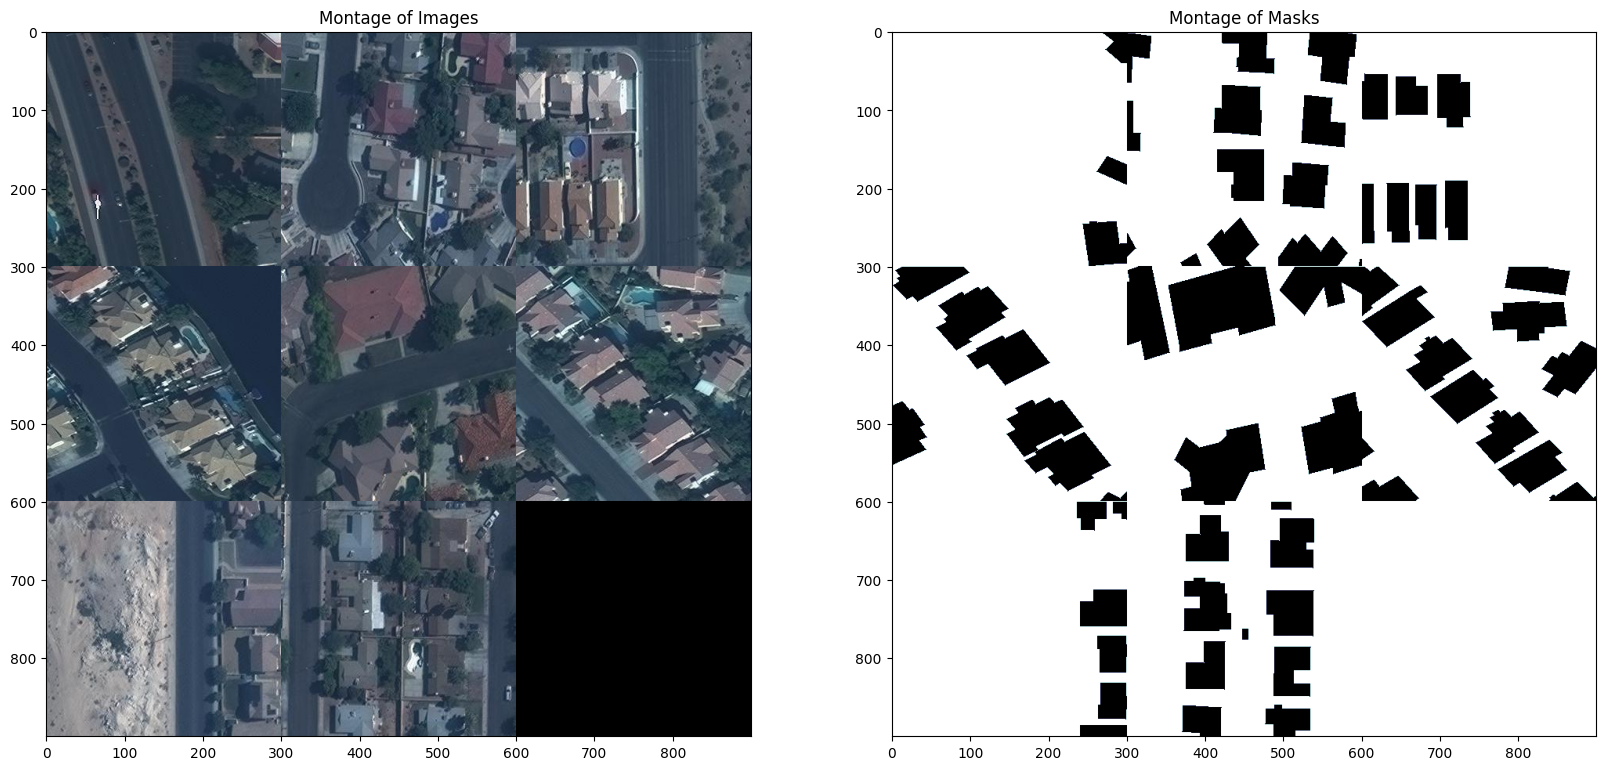

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_montage(image_list):
    """
    Create a montage from a list of images.

    Args:
    - image_list: List of images (2D or 3D arrays)

    Returns:
    - montage: Montage image
    """
    num_images = len(image_list)
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    # Determine dimensions of each image
    height, width = image_list[0].shape[:2]

    montage = np.zeros((rows * height, cols * width, image_list[0].shape[2]), dtype=image_list[0].dtype)

    for i, image in enumerate(image_list):
        r = i // cols
        c = i % cols
        montage[r * height:(r + 1) * height, c * width:(c + 1) * width] = image

    return montage

# Usage example
t_x_montage = create_montage(t_x)
t_y_montage = create_montage(t_y)

# Display the montages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(t_x_montage)
ax1.set_title('Montage of Images')
ax2.imshow(t_y_montage[:, :, 0], cmap='bone_r')
ax2.set_title('Montage of Masks')
plt.show()


In [ ]:
'''#from skimage.util import montage
from skimage.util import montage2d

t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')'''



"#from skimage.util import montage\nfrom skimage.util import montage2d\n\nt_x, t_y = next(valid_gen)\nprint('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())\nprint('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))\nmontage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)\nax1.imshow(montage_rgb(t_x))\nax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')"

In [ ]:
!pip install scikit-image


In [ ]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
#BATCH_SIZE = 24
#BATCH_SIZE = 32  # Change the batch size to 32
#BATCH_SIZE = 16 # Change the batch size to 16
#BATCH_SIZE = 8 # Change the batch size to 8
BATCH_SIZE = 4 # Change the batch size to 4

In [ ]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3),
                             activation='linear',
                             padding='same',
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True)
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 300, 300, 3)          0         ['RGB_Input[0][0]']           
 ise)                                                                                             
                                                                                                  
 batch_normalization (Batch  (None, 300, 300, 3)          12        ['gaussian_noise[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
'''import threading

# Define your batch_img_gen function with a lock
def batch_img_gen_for_loss_history(in_df, batch_size, lock):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img) >= batch_size:
                # Acquire the lock before yielding data
                with lock:
                    yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []

# Create a lock
lock = threading.Lock()

# Use the generator with the lock
valid_gen = batch_img_gen(valid_df, BATCH_SIZE, lock)'''

"import threading\n\n# Define your batch_img_gen function with a lock\ndef batch_img_gen_for_loss_history(in_df, batch_size, lock):\n    all_groups = list(in_df.groupby('image_id'))\n    out_img, out_seg = [], []\n    while True:\n        for (_, c_df) in np.random.permutation(all_groups):\n            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))\n            out_img += [img_data]\n            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]\n            if len(out_img) >= batch_size:\n                # Acquire the lock before yielding data\n                with lock:\n                    yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)\n                out_img, out_seg = [], []\n\n# Create a lock\nlock = threading.Lock()\n\n# Use the generator with the lock\nvalid_gen = batch_img_gen(valid_df, BATCH_SIZE, lock)"

In [ ]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE),
                              steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                              epochs=2,
                              validation_data=valid_gen,
                              validation_steps=min(train_ids.shape[0]//BATCH_SIZE, 50),
                              callbacks=callbacks_list,
                              workers=2,
                              use_multiprocessing=True)]


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: -0.3525 - dice_coef: 0.4215 - binary_accuracy: 0.6968 - true_positive_rate: 0.6354
Epoch 1: val_dice_coef improved from -inf to 0.36042, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 797s 8s/step - loss: -0.3525 - dice_coef: 0.4215 - binary_accuracy: 0.6968 - true_positive_rate: 0.6354 - val_loss: -0.2217 - val_dice_coef: 0.3604 - val_binary_accuracy: 0.3490 - val_true_positive_rate: 0.7908 - lr: 1.0000e-04
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: -0.3764 - dice_coef: 0.4535 - binary_accuracy: 0.7101 - true_positive_rate: 0.6293
Epoch 2: val_dice_coef improved from 0.36042 to 0.41551, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 754s 8s/step - loss: -0.3764 - dice_coef: 0.4535 - binary_accuracy: 0.7101 - true_positive_rate: 0.6293 - val_loss: -0.2896 - val_dice_coef: 0.4155 - val_binary_accuracy: 0.5312 - val

In [ ]:
'''valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE),
                              steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                              epochs=2,
                              validation_data=valid_gen,
                              validation_steps=min(train_ids.shape[0]//BATCH_SIZE, 50),
                              callbacks=callbacks_list,
                              workers=2)]'''


'valid_gen = batch_img_gen(valid_df, BATCH_SIZE)\nloss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE),\n                              steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),\n                              epochs=2,\n                              validation_data=valid_gen,\n                              validation_steps=min(train_ids.shape[0]//BATCH_SIZE, 50),\n                              callbacks=callbacks_list,\n                              workers=2)]'

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
'''t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)'''

"t_x, t_y = next(valid_gen)\nif t_x.shape[0]>16:\n    t_x = t_x[:16]\n    t_y = t_y[:16]\n\nprint('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())\nprint('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())\npred_y = seg_model.predict(t_x)\n\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))\nmontage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)\nax1.imshow(montage_rgb(t_x))\nax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')\nax2.set_title('Ground Truth')\nax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')\nax3.set_title('Prediction')\nfig.savefig('pred_fig.png', dpi=300)"

x (4, 300, 300, 3) float32 0.0 1.0
y (4, 300, 300, 1) float32 0.0 1.0
1/1 [==============================] - 1s 1s/step


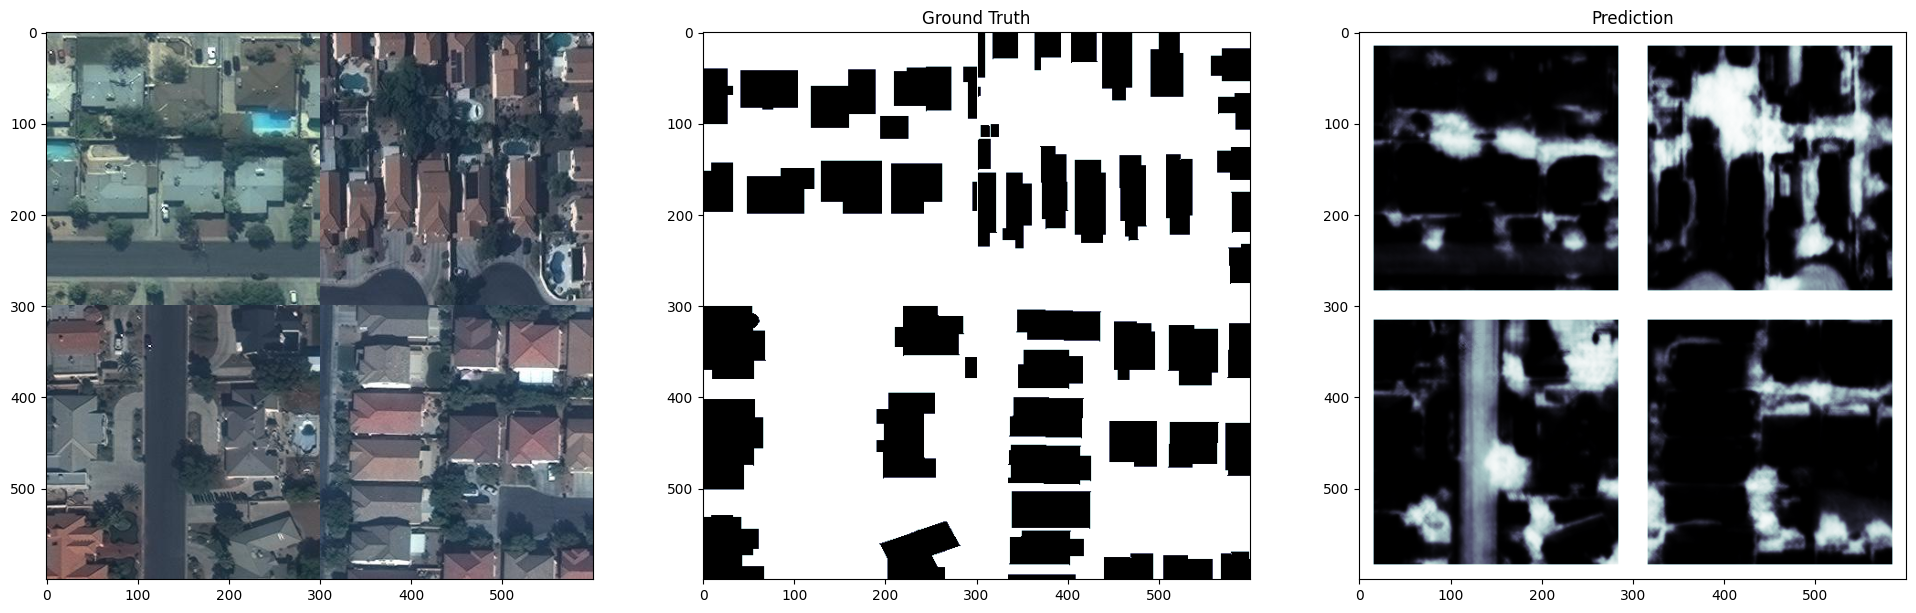

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0] > 16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
montage_rgb = lambda x: np.stack([create_montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(create_montage(t_y[:, :, :, 0]), cmap='bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(create_montage(pred_y[:, :, :, 0]), cmap='bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)
